# Milestone 2: Data Exploration & Initial Preprocessing

## Data exploration

We have 5 rice varieties in our image data, Arborio, Basmati, Ipsala, Jasmine, and Karacadag. The total number of the images is 75,000. Each of the varieties has 15,000 images from different angles and sizes. The image sizes are all 250x250 pixels, but the sizes of each rice are different. Every image is in a dark background with exactly one rice in the middle of the image. We will look at this image and use OpenCV to get the feature from those image datasets. The features we will extract are displayed in the next cell.

## The feature and explanations extract from the image datasets

In [1]:
import pandas as pd
from IPython.display import display, HTML

In [2]:
data = {
    "Variable Name": ["Area", "Perimeter", "Major_Axis_Length", "Minor_Axis_Length", "Eccentricity", "Convex_Area", "Extent"],
    "Role": ["Feature", "Feature", "Feature", "Feature", "Feature", "Feature", "Feature"],
    "Type": ["Integer", "Continuous", "Continuous", "Continuous", "Continuous", "Integer", "Continuous"],
    "Description": [
        "Returns the number of pixels within the boundaries of the rice grain",
        "Calculates the circumference by calculating the distance between pixels around the boundaries of the rice grain",
        "The longest line that can be drawn on the rice grain, i.e. the main axis distance",
        "The shortest line that can be drawn on the rice grain, i.e. the small axis distance",
        "It measures how round the ellipse, which has the same moments as the rice grain",
        "Returns the pixel count of the smallest convex shell of the region formed by the rice grain",
        "Returns the ratio of the region formed by the rice grain to the bounding box pixels"
    ]
}
df = pd.DataFrame(data)
display(HTML(df.to_html(index=False)))

Variable Name,Role,Type,Description
Area,Feature,Integer,Returns the number of pixels within the boundaries of the rice grain
Perimeter,Feature,Continuous,Calculates the circumference by calculating the distance between pixels around the boundaries of the rice grain
Major_Axis_Length,Feature,Continuous,"The longest line that can be drawn on the rice grain, i.e. the main axis distance"
Minor_Axis_Length,Feature,Continuous,"The shortest line that can be drawn on the rice grain, i.e. the small axis distance"
Eccentricity,Feature,Continuous,"It measures how round the ellipse, which has the same moments as the rice grain"
Convex_Area,Feature,Integer,Returns the pixel count of the smallest convex shell of the region formed by the rice grain
Extent,Feature,Continuous,Returns the ratio of the region formed by the rice grain to the bounding box pixels


## Retrieve the data

In [3]:
!git lfs install
!git clone https://huggingface.co/datasets/nateraw/rice-image-dataset
!unzip /content/rice-image-dataset/rice-image-dataset.zip -d /content/rice-image-dataset/

Streaming output truncated to the last 5000 lines.
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: /content/rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: /content/

## install opencv and pandas (colab notebook already install)

In [4]:
!pip install opencv-python-headless pandas

## Getting the features from image

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Extract the features from the given image
# param image_path: The image path
# return: The list of data for each feature
def extract_features(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Check if the image is loaded successfully
    if image is None:
        print(f"Failed to load image: {image_path}")
        return []

    # Binary thresholding
    _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Show the original image and contours
    #image_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    #cv2.drawContours(image_contours, contours, -1, (0, 255, 0), 2)
    #plt.imshow(image_contours)
    #plt.title("Contours")
    #plt.show()

    # Initialize feature list
    features_list = []

    for contour in contours:
        # Calculate features
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        x, y, w, h = cv2.boundingRect(contour)
        major_axis_length = max(w, h)
        minor_axis_length = min(w, h)
        eccentricity = 0  # Default value for eccentricity
        if len(contour) >= 5:  # fitEllipse needs at least 5 points
            (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
            if MA < ma:
              MA, ma = ma, MA
            if MA > 0 and ma > 0:
              eccentricity = np.sqrt(1 - (ma/MA)**2)
        hull = cv2.convexHull(contour)
        convex_area = cv2.contourArea(hull)
        extent = area / (w * h) if w * h > 0 else 0

        # Append features to list
        features = [area, perimeter, major_axis_length, minor_axis_length, eccentricity, convex_area, extent]
        features_list.append(features)

    return features_list

In [7]:
# Define the main directory path
main_directory_path = '/content/rice-image-dataset/Rice_Image_Dataset'

# Get all class subdirectories
classes = os.listdir(main_directory_path)
classes.remove('Rice_Citation_Request.txt')
all_features = []

# Iterate through each class subdirectory
for class_name in classes:
    class_path = os.path.join(main_directory_path, class_name)
    if os.path.isdir(class_path):
        # Get all image files in the class directory
        for filename in os.listdir(class_path):
            if filename.endswith(".png") or filename.endswith(".jpg"):
                image_path = os.path.join(class_path, filename)
                features = extract_features(image_path)

                # add class
                features[0].append(class_name)
                if features:
                    all_features.extend(features)

# Initialize DataFrame
columns = ["Area", "Perimeter", "Major_Axis_Length", "Minor_Axis_Length", "Eccentricity", "Convex_Area", "Extent", "Class"]
df = pd.DataFrame(all_features, columns=columns)

# Drop rows with NaN values
df = df.dropna()

# Add additional columns
df['Variable Name'] = ["Feature"] * len(df)
df['Role'] = ["Feature"] * len(df)
df['Type'] = ["Continuous"] * len(df)
df['Description'] = [""] * len(df)
df['Units'] = [""] * len(df)
df['Missing Values'] = ["no"] * len(df)

# Rearrange column order
df = df[["Area", "Perimeter", "Major_Axis_Length", "Minor_Axis_Length", "Eccentricity", "Convex_Area", "Extent", "Class"]]


In [8]:
# Display the DataFrame
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',504)
pd.set_option('display.width', 1000)
print(df)

          Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  Convex_Area    Extent    Class
0       7233.5  351.747255                119                 99      0.868372       7344.5  0.613997  Arborio
1       8982.5  398.232537                125                116      0.859786       9198.0  0.619483  Arborio
2       7456.5  369.060964                119                103      0.858012       7718.5  0.608346  Arborio
3       7494.0  357.989897                110                110      0.858129       7644.5  0.619339  Arborio
4       5935.5  326.835567                122                 73      0.894907       6036.0  0.666461  Arborio
...        ...         ...                ...                ...           ...          ...       ...      ...
74995  14734.5  518.776692                204                 94      0.870728      15216.0  0.768382   Ipsala
74996  12284.0  477.989895                185                 97      0.887866      12651.5  0.684536   Ipsala
7

In [9]:
# Count the number of classes and images
num_classes = len(classes)
num_images = len(all_features)

print(f"Number of classes: {num_classes}")
print(f"Number of images: {num_images}")

Number of classes: 5
Number of images: 75000


## Example image for each rice varieties

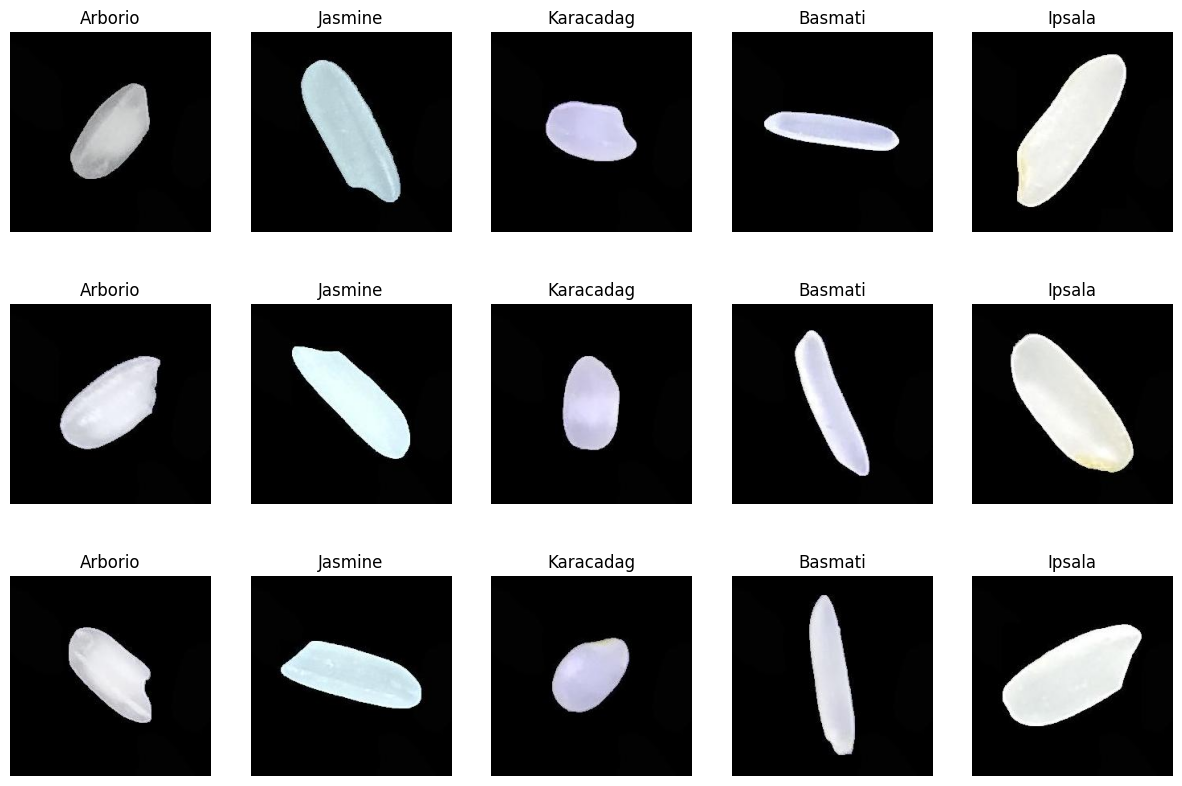

In [10]:
# Plot three images for each variety
fig, axs = plt.subplots(3, len(classes), figsize=(15, 10))

for i, class_name in enumerate(classes):
    class_path = os.path.join(main_directory_path, class_name)
    if os.path.isdir(class_path):
        image_paths = os.listdir(class_path)[:3]
        for j, image_path in enumerate(image_paths):
            image_path = os.path.join(class_path, image_path)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Plot the image
            axs[j, i].imshow(image, cmap='gray')
            axs[j, i].set_title(class_name)
            axs[j, i].axis('off')

plt.show()

## Data Exploration

               Area     Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity   Convex_Area        Extent
count  75000.000000  75000.000000       75000.000000       75000.000000  75000.000000  75000.000000  75000.000000
mean    8206.674293    398.497899         148.066867          91.670333      0.889055   8414.327127      0.619275
std     3092.094279     74.269905          33.308083          24.762705      0.072231   3162.466775      0.121558
min     3808.500000    277.521860          86.000000          37.000000      0.610742   3907.000000      0.271136
25%     6118.500000    333.379724         119.000000          75.000000      0.848184   6246.500000      0.548034
50%     7179.000000    370.232535         141.000000          88.000000      0.888345   7366.500000      0.642242
75%     8705.625000    468.835567         179.000000         105.000000      0.955154   8959.500000      0.711852
max    20740.000000    625.587875         242.000000         179.000000      0.989206  2

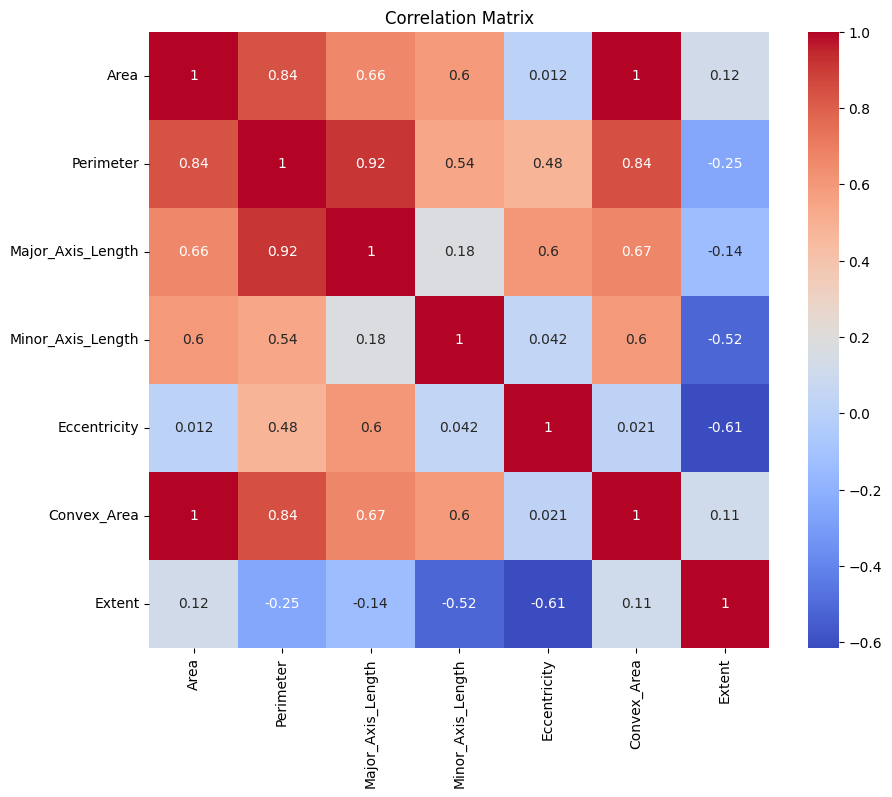

In [11]:
import seaborn as sns

# View descriptive statistics
print(df.describe())

# Check the number of missing values ​​in each column
print(df.isnull().sum())

# Plotting a heatmap of the correlation matrix
corr = df.drop(columns=['Class']).corr()
# corr = df
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

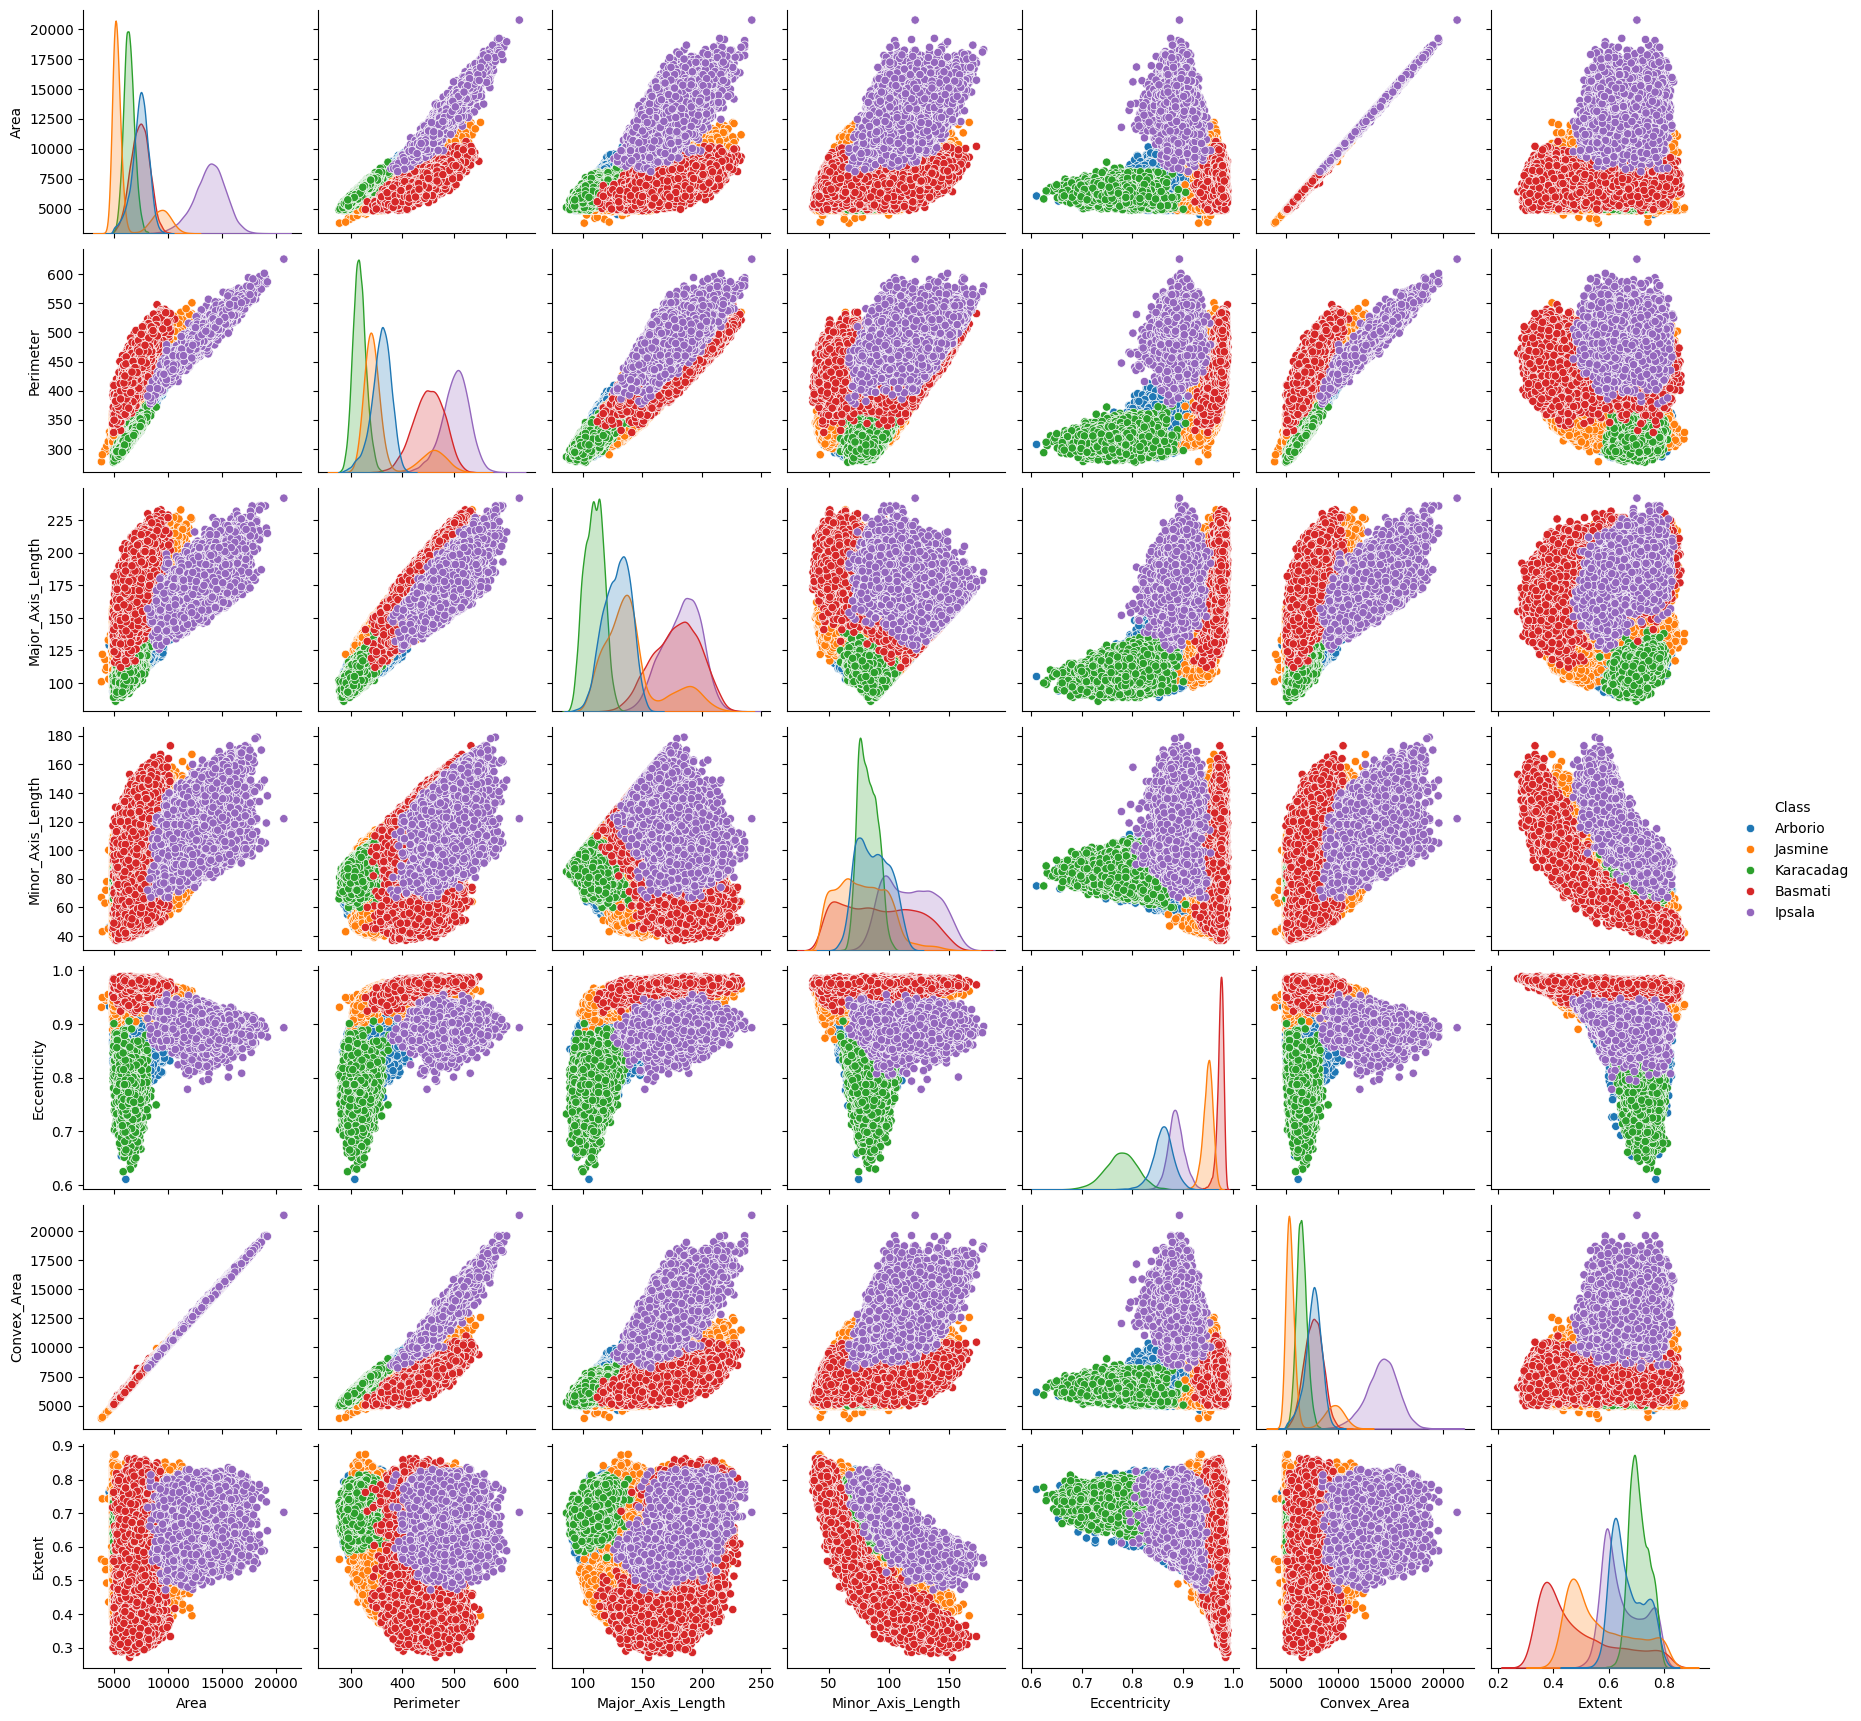

In [12]:
#show pairplot
sns.pairplot(df, diag_kind='kde', hue='Class')
plt.show()

In [13]:
# Class encoding
new_label = { label:idx for idx, label in enumerate(df['Class'].unique()) } # {'Basmati': 0, 'Jasmine': 1, 'Arborio': 2, 'Ipsala': 3, 'Karacadag': 4}
df['Class'] = df['Class'].map(new_label)

               Area     Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity   Convex_Area        Extent         Class
count  75000.000000  75000.000000       75000.000000       75000.000000  75000.000000  75000.000000  75000.000000  75000.000000
mean    8206.674293    398.497899         148.066867          91.670333      0.889055   8414.327127      0.619275      2.000000
std     3092.094279     74.269905          33.308083          24.762705      0.072231   3162.466775      0.121558      1.414223
min     3808.500000    277.521860          86.000000          37.000000      0.610742   3907.000000      0.271136      0.000000
25%     6118.500000    333.379724         119.000000          75.000000      0.848184   6246.500000      0.548034      1.000000
50%     7179.000000    370.232535         141.000000          88.000000      0.888345   7366.500000      0.642242      2.000000
75%     8705.625000    468.835567         179.000000         105.000000      0.955154   8959.500000     

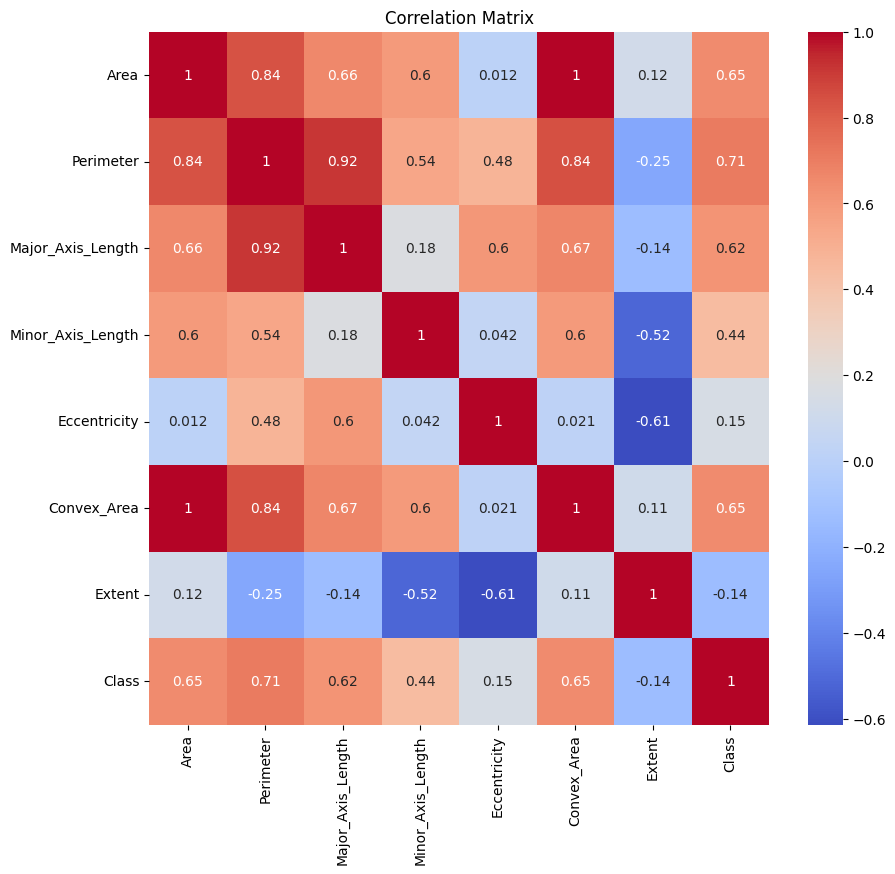

In [14]:
# View descriptive statistics
print(df.describe())

# Check the number of missing values ​​in each column
print(df.isnull().sum())

# Plotting a heatmap of the correlation matrix
corr = df.corr()
plt.figure(figsize=(10, 9))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Preprocess the data
The process of preprocess the data will be in [README](https://github.com/Astraeven0502/CSE151A_Group_Project-Rice_Classification/blob/main/README.md)


# Milestone 3: Pre-Processing

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

## Normalize and Standardize data

In [17]:
def preprocess_rice_data(df):
    # # Extract features that are highly correlated with `Class`
    features = df[['Perimeter','Area','Convex_Area']]
    labels = df['Class']

    # Normalize features
    normalizer = MinMaxScaler()
    normalized_features = normalizer.fit_transform(features)

    # Standardize features
    scaler = StandardScaler()
    standardized_features = scaler.fit_transform(normalized_features)

    # Combine normalized and standardized features with original class labels
    processed_data = pd.DataFrame(standardized_features, columns=features.columns)
    processed_data['Class'] = labels.values

    return processed_data

In [18]:
df_pre = preprocess_rice_data(df)
df_pre

,Perimeter,Area,Convex_Area,Class
0,-0.629474,-0.314732,-0.338291,0
1,-0.003573,0.250908,0.247806,0
2,-0.396353,-0.242612,-0.220028,0
3,-0.545420,-0.230484,-0.243428,0
4,-0.964897,-0.734515,-0.752053,0
...,...,...,...,...
74995,1.619493,2.111148,2.150764,4
74996,1.070319,1.318638,1.339841,4
74997,1.394821,1.712063,1.770362,4
74998,0.830665,1.040184,1.012562,4


## Model 1 - Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, log_loss

In [23]:
# Make a list for every possible pair
df_list = []
for i in range(5):
  for j in range(i+1, 5):
    df_list.append([i, j])
df_list = df_list[:10]
print(df_list)

[[0, 1], [0, 2], [0, 3], [0, 4], [1, 2], [1, 3], [1, 4], [2, 3], [2, 4], [3, 4]]


In [145]:
def model_train(df_list):
    df_0_1 = df_pre[(df_pre['Class']==df_list[0]) | (df_pre['Class']==df_list[1])]
    X = df_0_1.drop('Class', axis=1)
    y = df_0_1['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    cost = log_loss(y_test, y_pred_proba)
    return [model, cost]

In [146]:
model_list = []

In [147]:
for pair in df_list:
  model_t = model_train(pair)
  model_list.append(model_t)
  print(model_t[1])

0.02711252759412644
0.11921892152031281
0.0035515652688723484
0.006650458774334567
0.006763589117799963
0.10901242964504945
0.012987202908194889
0.001912227906744682
0.0006341186155457516
0.0020462986383747383


In [148]:
# The model for each pair
model_list

[[LogisticRegression(), 0.02711252759412644],
 [LogisticRegression(), 0.11921892152031281],
 [LogisticRegression(), 0.0035515652688723484],
 [LogisticRegression(), 0.006650458774334567],
 [LogisticRegression(), 0.006763589117799963],
 [LogisticRegression(), 0.10901242964504945],
 [LogisticRegression(), 0.012987202908194889],
 [LogisticRegression(), 0.001912227906744682],
 [LogisticRegression(), 0.0006341186155457516],
 [LogisticRegression(), 0.0020462986383747383]]

## Split the data

In [149]:
X = df_pre.drop('Class', axis=1)
y = df_pre['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)
y_test.unique()

array([1, 0, 4, 2, 3])

In [150]:
print(X_train)
print(X_test)
print(y_train)
print(y_test)

       Perimeter      Area  Convex_Area
67421   0.796642  0.954643     1.015092
72519   0.909306  1.382834     1.356600
51720   0.947718  0.106021     0.098080
67521   1.547154  2.056816     2.083569
20707  -0.522879 -0.924679    -0.903360
...          ...       ...          ...
37194  -1.165347 -0.607416    -0.626043
6265   -0.555221 -0.297915    -0.307460
54886   0.335117 -0.715919    -0.662407
860    -0.582150 -0.236791    -0.258606
15795   0.867395  0.333053     0.352788

[7500 rows x 3 columns]
       Perimeter      Area  Convex_Area
26837  -0.710589 -1.011028    -0.987156
2592   -1.330748 -0.920151    -0.922965
18359  -0.736958 -0.989845    -0.971662
73292   1.824659  2.319908     2.331636
60127   1.126091  1.635901     1.667119
...          ...       ...          ...
28314  -0.594425 -0.936968    -0.911898
6791   -0.266889 -0.019299     0.004482
68100   1.065699  1.190569     1.145529
13450  -0.637129 -0.322494    -0.328172
40612  -0.913746 -0.510070    -0.501456

[67500 rows x 

## Evaluate model

In [154]:
# Train Error
train_output_matrix = model_list[0][0].predict(X_train)
for model in model_list[1:]:
  train_output_matrix = np.vstack((train_output_matrix, model[0].predict(X_train)))
train_yhat = []

for i in range(train_output_matrix.shape[1]):
  counts = np.bincount(train_output_matrix.T[i])
  train_yhat.append(np.argmax(counts))

train_accuracy = np.mean(train_yhat==y_train)
print(f"test_accuracy: {train_accuracy}")

test_accuracy: 0.9626666666666667


In [155]:
# Test Error
test_output_matrix = model_list[0][0].predict(X_test)
for model in model_list[1:]:
  test_output_matrix = np.vstack((test_output_matrix, model[0].predict(X_test)))
test_output_matrix

yhat = []
for i in range(test_output_matrix.shape[1]):
  counts = np.bincount(test_output_matrix.T[i])
  yhat.append(np.argmax(counts))

test_accuracy = np.mean(yhat==y_test)
print(f"test_accuracy: {test_accuracy}")

test_accuracy: 0.9664148148148148


In [153]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     13460
           1       0.95      0.96      0.96     13429
           2       0.95      0.97      0.96     13522
           3       0.97      0.96      0.96     13533
           4       1.00      0.99      1.00     13556

    accuracy                           0.97     67500
   macro avg       0.97      0.97      0.97     67500
weighted avg       0.97      0.97      0.97     67500

